# Cryptolytic Arbitrage Modeling

This notebook contains the code to create the arbitrage models used in the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_data_processing.ipynb) and model evaluation in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_model_evaluation.ipynb).

#### Background on Arbitrage Models
Arbitrage models were created with the goal of predicting arbitrage 10 min before it happens in an active crypto market. The models are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the model have a direction indicating which direction the arbitrage occurs in. A valid arbitrage signal is when the arbitrage lasts >30 mins because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades.

The models predict whether there will be an arbitrage opportunity that starts 10 mins after the prediction time and lasts for at least 30 mins, giving a user enough times to execute trades.

#### Baseline Logistic Regression


#### Baseline Random Forest with default parameters

#### Feature Selection

#### Random Forest with hyperparameter tuning

More than 6000+ iterations of models were generated in this notebook and the best ones were selected from each possible arbitrage combination based on model selection criteria outlined later in this section. The models were Random Forest Classifier and the best model parameters varied for each dataset. The data was obtained from the respective exchanges via their api, and we did a 70/30 train/test split on 5 min candlestick data that fell anywhere in the range from Jun 2015 - Oct 2019. There was a 2 week gap left between the train and test sets to prevent data leakage. The models return 0 (no arbitrage), 1 (arbitrage from exchange 1 to exchange 2) and -1 (arbitrage from exchange 2 to exchange 1). 

The profit calculation incorporated fees like in the real world. We used mean percent profit as the profitability metric which represented the average percent profit per arbitrage trade if one were to act on all trades predicted by the model in the testing period, whether those predictions were correct or not.

From the 6000+ iterations of models trained, the best models were narrowed down based on the following criteria:
- How often the models predicted arbitrage when it didn't exist (False positives)
- How many times the models predicted arbitrage correctly (True positives)
- How profitable the model was in the real world over the period of the test set. 

There were 21 models that met the thresholds for model selection critera (details of these models can be found at the end of this nb). The final models were all profitable with gains anywhere from 0.2% - 2.3% within the varied testing time periods (Note: the model with >9% mean percent profit was an outlier). Visualizations for how these models performed can be viewed at https://github.com/Lambda-School-Labs/cryptolytic-ds/blob/master/finalized_notebooks/visualization/arb_performance_visualization.ipynb

\* It is HIGHLY recommended to run this on sagemaker and split the training work onto 4 notebooks. These functions will take over a day to run if not split up. There are 95 total options for models, 75 of those options have enough data to train models, and with different options for parameters around ~6K models will be trained. After selecting for the best models, there were 21 that met the criteria to be included in this project.

\*** There has been some feature selection done in this process where we removed highly correlated features, but not enough. There should be more exploration into whether removing features improves accuracy. 

\**** We haven't tried normalizing the dataset to see if it will improve accuracy, but that should be a top priority to anyone continuing this project

#### Directory Structure
```
├── cryptolytic/                        <-- The top-level directory for all arbitrage work
│   ├── modeling/                       <-- Directory for modeling work
│   │      ├──data/                     <-- Directory with subdirectories containing 5 min candle data
│   │      │   ├─ arb_data/             <-- Directory for csv files of arbitrage model training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ csv_data/             <-- Directory for csv files after combining datasets and FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ *.zip                 <-- ZIP files of all of the data
│   │      │   
│   │      ├──final_models/             <-- Directory for final models after model selection
│   │      │      └── *.pkl
│   │      │
│   │      ├──model_perf/               <-- Directory for performance csvs after training models
│   │      │      └── *.json
│   │      │
│   │      ├──models/                   <-- Directory for all pickle models
│   │      │      └── *.pkl
│   │      │
│   │      ├─arbitrage_data_processing.ipynb      <-- Notebook for data processing and creating csvs
│   │      │
│   │      ├─arbitrage_modeling.ipynb             <-- Notebook for baseline models and hyperparam tuning
│   │      │
│   │      ├─arbitrage_model_selection.ipynb      <-- Notebook for model selection
│   │      │
│   │      ├─arbitrage_model_evaluation.ipynb     <-- Notebook for final model evaluation
│   │      │
│   │      ├─environment.yml                      <-- yml file to create conda environment
│   │      │
│   │      ├─trade_recommender_models.ipynb       <-- Notebook for trade recommender models

```

## Imports

## Imports

This project uses conda to manage environments.

In [1]:
# to update your conda env from a yml file from terminal
# conda env update --file modeling/environment.yml

# to export yml from terminal
# conda env export > modeling/environment.yml

In [1]:
import glob
import os
import pickle
import json
import itertools
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

## Data

Store all the arbitrage datasets that will be used in modeling into a list variable.

In [4]:
arb_data_paths = glob.glob('data/arb_data/*.csv')
print(len(arb_data_paths))

95


Each dataset looks like this and should have 141 columns.

In [5]:
df = pd.read_csv(arb_data_paths[0], index_col=0)
print(df.shape)
df.head()

(451520, 141)


,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,...,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,278.04,278.05,277.99,277.99,9.115813,0.0,-11.656990,-98329.562325,-0.394465,2.499380,...,2015,7,20,1,0.007195,0,10,0.0,45.0,0
1,277.96,278.25,277.95,278.19,16.981369,0.0,1.073009,-98312.580956,-0.341762,2.166029,...,2015,7,20,1,0.071945,0,15,0.0,50.0,0
2,278.15,278.25,278.15,278.23,8.926014,0.0,15.544430,-98303.654941,-0.322681,-0.045552,...,2015,7,20,1,0.086334,0,20,0.0,55.0,0
3,278.21,278.23,278.21,278.23,1.613097,0.0,6.968705,0.000000,-0.331044,-0.614731,...,2015,7,20,1,0.104339,0,25,0.0,60.0,0
4,278.22,278.22,278.22,278.22,0.059885,0.0,1.613097,-98303.714827,-0.504553,0.088661,...,2015,7,20,1,0.079137,0,30,0.0,65.0,0


## Modeling Functions

#### Functions for print statements

In [2]:
line = '-------------'
sp = '      '

def tbl_stats_headings():
    """Prints the headings for the stats table"""
    print(sp*2, line*9, '\n', 
          sp*3, 'Accuracy Score', 
#           sp, 'True Positive Rate',
#           sp, 'False Postitive Rate', 
          sp, 'Precision',
          sp, 'Recall',
          sp, 'F1', '\n',
          sp*2, line*9, '\n', 
    )
    
def tbl_stats_row(test_accuracy, precision, recall, f1):
    """Prints the row of model stats after each param set fold"""
    print(
        sp*4, f'{test_accuracy:.4f}',     # accuracy
#         sp*3, f'{tpr:.4f}',           # roc auc
#         sp*3, f'{fpr:.4f}',      # p/r auc
        sp*2, f'{precision:.4f}',      # p/r auc
        sp*1, f'{recall:.4f}',      # p/r auc
        sp*1, f'{f1:.4f}',     # p/r auc
        sp*2, line*9
    )

def print_model_name(name, i, arb_data_paths):
    print(
    '\n\n', line*9, '\n\n', 
    f'Model {i+1}/{len(arb_data_paths)}: {name}', '\n', 
    line*9
    )

def print_model_params(i, params, pg_list):  
    print(
        sp*2, line*5, '\n', 
        sp*2, f'Model {i+1}/{len(pg_list)}', '\n',  
        sp*2, f'params={params if params else None}', '\n', 
        sp*2, line*5
    )

In [3]:
# specifying arbitrage window length to target, in minutes
interval = 30

def get_higher_closing_price(df):
    """
    Returns the exchange with the higher closing price
    """
    # exchange 1 has higher closing price
    if (df['close_exchange_1'] - df['close_exchange_2']) > 0:
        return 1
    
    # exchange 2 has higher closing price
    elif (df['close_exchange_1'] - df['close_exchange_2']) < 0:
        return 2
    
    # closing prices are equivalent
    else:
        return 0

def get_close_shift(df, interval=interval):
    """
    Shifts the closing prices by the selected interval +
    10 mins.
    
    Returns a df with new features:
    - close_exchange_1_shift
    - close_exchange_2_shift
    """
    
    rows_to_shift = int(-1*(interval/5))
    
    df['close_exchange_1_shift'] = df['close_exchange_1'].shift(
        rows_to_shift - 2)
    
    df['close_exchange_2_shift'] = df['close_exchange_2'].shift(
        rows_to_shift - 2)
    
    return df

def get_profit(df):
    """
    Calculates the profit of an arbitrage trade.
    
    Returns df with new profit feature.
    """
    
    # if exchange 1 has the higher closing price
    if df['higher_closing_price'] == 1:
        
        # return how much money you would make if you bought 
        # on exchange 2, sold on exchange 1, and took account 
        # of 0.55% fees
        return (((df['close_exchange_1_shift'] / 
                 df['close_exchange_2'])-1)*100)-.55
    
    # if exchange 2 has the higher closing price
    elif df['higher_closing_price'] == 2:
        
        # return how much money you would make if you bought 
        # on exchange 1, sold on exchange 2, and took account 
        # of 0.55% fees
        return (((df['close_exchange_2_shift'] / 
                 df['close_exchange_1'])-1)*100)-.55
    
    # if the closing prices are the same
    else:
        return 0 # no arbitrage

def profit(X_test, y_preds):  
    # creating dataframe from test set to calculate profitability
    test_with_preds = X_test.copy()

    # add column with higher closing price
    test_with_preds['higher_closing_price'] = test_with_preds.apply(
            get_higher_closing_price, axis=1)

    # add column with shifted closing price
    test_with_preds = get_close_shift(test_with_preds)

    # adding column with predictions
    test_with_preds['pred'] = y_preds

    # adding column with profitability of predictions
    test_with_preds['pct_profit'] = test_with_preds.apply(
            get_profit, axis=1).shift(-2)

    # filtering out rows where no arbitrage is predicted
    test_with_preds = test_with_preds[test_with_preds['pred'] != 0]

    # calculating mean profit where arbitrage predicted...
    pct_profit_mean = round(test_with_preds['pct_profit'].mean(), 2)

    # calculating median profit where arbitrage predicted...
    pct_profit_median = round(test_with_preds['pct_profit'].median(), 2)
    
    return pct_profit_mean, pct_profit_median

In [4]:
def feat_and_params(df, features, param_grid):
    """
    Selects the correct features and parameters
    for each model
    """
    
    if features and param_grid:
        pg_list = list(ParameterGrid(param_grid))
    # if theres features and no parms
    elif features and not param_grid:
        pg_list = [param_grid]
    # if theres params and no features
    elif not features and param_grid:
        features = df.drop(
            labels=['target', 'closing_time'], 
            axis=1
        ).columns.to_list()
        pg_list = list(ParameterGrid(param_grid))
    # baseline: no features and no params
    else:
        features = df.drop(
            labels=['target', 'closing_time'], 
            axis=1
        ).columns.to_list()
        pg_list = [param_grid]
    
    return features, pg_list

In [5]:
def create_models(arb_data_paths, model_type, features, param_grid):
    """
    This function takes in a list of all the arbitrage data paths, 
    does train/test split, feature selection, trains models, 
    saves the pickle file, and prints performance stats for each model

    Predictions
    ___________
    
    Models predict whether arbitrage will in 10 mins from the 
    prediction time, and last for at least 30 mins:
    1: arbitrage from exchange 1 to exchange 2
    0: no arbitrage
    -1: arbitrage from exchange 2 to exchange 1
    
    Evaluation
    __________
    
    - Accuracy Score
    - Precision
    - Recall
    - F1 score
    - Mean Percent Profit
    - Median Percent Profit

    Parameters
    __________
    
    arb_data_paths: filepaths for all the datasets used in modeling
    model_type: scikit-learn model (LogisticRegression() or 
        RandomForestClassifier())
    features: the features for training or empty [] for all features
    param_grid: the params used for hyperparameter tuning or empty {} 
    """
    target = 'target'
    base_model_name = str(model_type).split('(')[0]
    model_name_dict = {
        'LogisticRegression':'lr',
        'RandomForestClassifier':'rf'
    }
    
    # this is part of a check put in the code to allow the function
    # to pick up where it previously left off in case of errors
    model_paths = glob.glob('models2/*.pkl')
    
    # iterate through the arbitrage csvs
    for i, file in enumerate(arb_data_paths):
        
        # read csv
        df = pd.read_csv(file, index_col=0)
        
        # convert str closing_time to datetime
        df['closing_time'] = pd.to_datetime(df['closing_time'])
        
        # print status
        name = file.split('/')[2].split('.')[0]
        print_model_name(name, i, arb_data_paths)
        
        # this makes the function dynamic for whether you want
        # to select features/hyperparameters or not
        features, pg_list = feat_and_params(df, features, param_grid)

        # hyperparameter tuning
        for i, params in enumerate(pg_list): 
            # define model name
            if param_grid:
                model_name = '_'.join([
                    name, 
                    str(params['max_features']), 
                    str(params['max_depth']), 
                    str(params['n_estimators'])
                ])
            else:
                model_name = name + '_' + model_name_dict[base_model_name]

            # define model filename to check if it exists
            model_path = f'models/{model_name}.pkl'

            # if the model does not exist
            if model_path not in model_paths:
                
                # print status
                print_model_params(i, params, pg_list)

                # remove 2 weeks from train datasets to create a  
                # two week gap between the data - prevents data leakage
                tt_split_row = round(len(df)*.82)
                tt_split_time = df['closing_time'][tt_split_row]
                cutoff_time = tt_split_time - dt.timedelta(days=14)

                # train and test subsets
                train = df[df['closing_time'] < cutoff_time]
                test = df[df['closing_time'] > tt_split_time]

                # X, y matrix
                X_train = train[features]
                X_test = test[features]
                y_train = train[target]
                y_test = test[target]
            
                # printing shapes to track progress
                print(sp*2, 'train and test shape: ', train.shape, test.shape)
  
                # filter out datasets that are too small
                if ((X_train.shape[0] > 1000) 
                    and (X_test.shape[0] > 100) 
                    and len(set(y_train)) > 1):

                    model = model_type.set_params(**params)

                    # there was a weird error caused by two of the datasets which
                    # is why this try/except is needed to keep the function running
#                         try:

                    # fit model
                    model = model.fit(X_train, y_train)

                    # make predictions
                    y_preds = model.predict(X_test)

                    pct_prof_mean, pct_prof_median = profit(X_test, y_preds)
                    print(sp*2,'percent profit mean:', pct_prof_mean)
                    print(sp*2, 'percent profit median:', pct_prof_median, '\n\n')

                    # classification report
                    print(classification_report(y_test, y_preds))

                    # save model
                    pickle.dump(model, open(f'models/{model_name}.pkl', 'wb'))

#                         except:
#                             print(line*3 + '\n' + line + 'ERROR' + line + '\n' + line*3)
#                             break # break out of for loop if there is an error with modeling

                # dataset is too small
                else:
                    print(f'{sp*2}ERROR: dataset too small for {name}')

            # the model exists
            else:
                print(f'{sp*2}{model_path} already exists.')

## Class Distribution

In [6]:
def class_distribution(arb_data_paths):
    """
    Returns the class distribution for all arbitrage
    datasets in a df
    """
    dist_df = pd.DataFrame(columns=[
        'arbitrage_combination', 
        'ex1_to_ex2_arb', 
        'ex2_to_ex1_arb',
        'no_arb'
    ])
    
    for path in arb_data_paths:
        df = pd.read_csv(path, index_col=0)
        arbitrage_combination = path.split('/')[2][:-4]
        value_counts = df.target.value_counts()
        
        # not every dataset has all 3 classes so a conditional
        # is required to deal with each case
        if len(value_counts) == 1: # just 0
            no_arb = round(value_counts[0] / value_counts.sum(), 2)
            ex1_to_ex2_arb = 0
            ex2_to_ex1_arb = 0
        elif len(value_counts) == 2:
            # if 0, -1
            if value_counts.index[0] == -1 or value_counts.index[1] == -1:
                no_arb = round(value_counts[0] / value_counts.sum(), 2)
                ex1_to_ex2_arb = 0
                ex2_to_ex1_arb = round(value_counts[-1] / value_counts.sum(), 2)
            # if 0, 1
            else:
                no_arb = round(value_counts[0] / value_counts.sum(), 2)
                ex1_to_ex2_arb = round(value_counts[1] / value_counts.sum(), 2)
                ex2_to_ex1_arb = 0
        else: # has all classes
            no_arb = round(value_counts[0] / value_counts.sum(), 2)
            ex1_to_ex2_arb = round(value_counts[1] / value_counts.sum(), 2)
            ex2_to_ex1_arb = round(value_counts[-1] / value_counts.sum(), 2)

        # append results to df
        dist_dict = {
                'arbitrage_combination': arbitrage_combination,
                'ex1_to_ex2_arb': ex1_to_ex2_arb,
                'ex2_to_ex1_arb': ex2_to_ex1_arb,
                'no_arb': no_arb
        }
        dist_df = dist_df.append(dist_dict, ignore_index=True)
        
    return dist_df

In [171]:
dist_df = class_distribution(arb_data_paths)
dist_df

,arbitrage_combination,ex1_to_ex2_arb,ex2_to_ex1_arb,no_arb
0,kraken_bitfinex_bch_btc,0.00,0.00,1.00
1,kraken_gemini_eth_btc,0.01,0.01,0.98
2,bitfinex_gemini_btc_usd,0.00,0.00,1.00
3,cbpro_gemini_bch_btc,0.15,0.16,0.70
4,bitfinex_kraken_btc_usd,0.00,0.00,1.00
...,...,...,...,...
90,kraken_bitfinex_eos_btc,0.00,0.00,0.99
91,kraken_gemini_btc_usd,0.00,0.00,1.00
92,gemini_bitfinex_bch_btc,0.16,0.16,0.68
93,kraken_cbpro_ltc_usd,0.00,0.00,1.00


## Baseline

#### Logistic Regression

In [139]:
create_models(
    arb_data_paths=arb_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial'
    ), 
    features=[], 
    param_grid={}
)



 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/95: kraken_bitfinex_bch_btc 
 ---------------------------------------------------------------------------------------------------------------------
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             train and test shape:  (4133, 141) (1791, 141)
             percent profit mean: nan
             percent profit median: nan 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791

    accuracy                           1.00      1791
   macro avg       1.00      1.00      1.00      1791
weighted avg       1.00      1.00      1.00      1791



 -------------------------------------------------------------------------------------------

#### Random Forest w/ default parameters

In [140]:
create_models(
    arb_data_paths=arb_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=[], 
    param_grid={}
)



 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/95: kraken_bitfinex_bch_btc 
 ---------------------------------------------------------------------------------------------------------------------
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             train and test shape:  (4133, 141) (1791, 141)
             percent profit mean: nan
             percent profit median: nan 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791

    accuracy                           1.00      1791
   macro avg       1.00      1.00      1.00      1791
weighted avg       1.00      1.00      1.00      1791



 -------------------------------------------------------------------------------------------

## Feature Selection

#### Feature Importances

In [147]:
def plot_feature_importances(arb_data_paths, pkls):
    """
    
    """
    # get column names
    df = pd.read_csv(arb_data_paths[0], index_col=0)
    columns = df.drop(labels=['target', 'closing_time'], axis=1).columns.to_list()

    mfi = []
    titles = {}
    n = 0
    
    # generate titles and feature importances
    for pkl in pkls:
        with open(pkl, 'rb') as f:
            model = pickle.load(f)
            titles[n] = pkl.split('/')[1].split('.')[0]
            n += 1

        importances = pd.DataFrame(model.feature_importances_, columns).reset_index()
        importances = importances.rename(columns={'index': 'features', 0: 'importance'})
        importances = importances.sort_values(by='importance', ascending=False)[:10][::-1]
        mfi.append(importances)
    
    # figure and styles
    fig, ax = plt.subplots(nrows=34, ncols=2, figsize=(15, 200))
    plt.subplots_adjust(wspace=1)
    plt.style.use('dark_background')
    
    n = 0
    for row in ax:
        for col in row:
            try:
                col.barh(mfi[n]['features'], mfi[n]['importance'], color='#4EB9FF')
                col.set_yticklabels = mfi[n]['features']
                col.set_title(titles[n])
                col.set_xlabel('Feature Importance')
                n += 1
            except:
                pass

    plt.show()

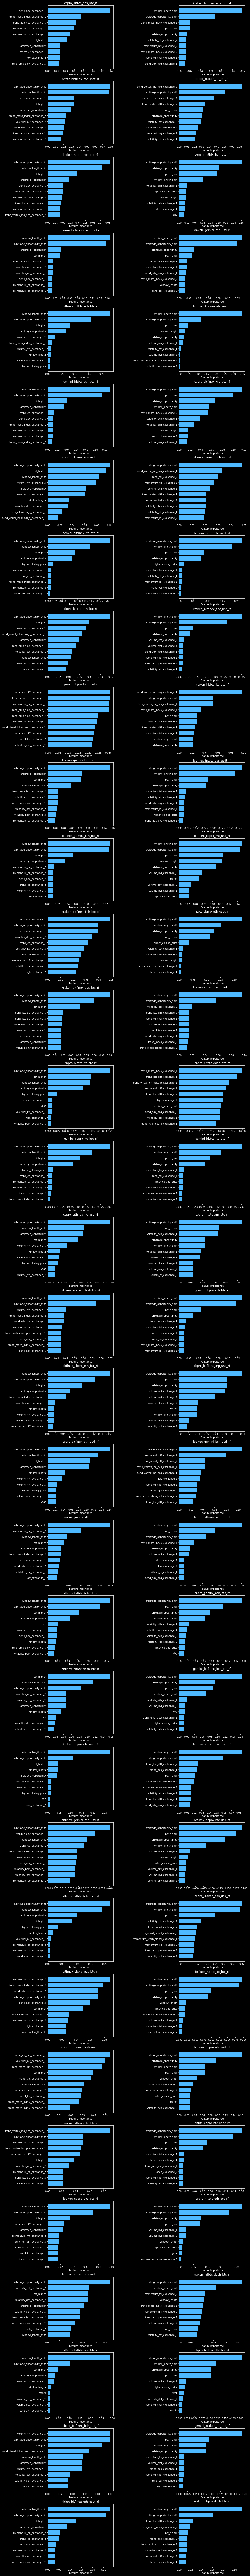

In [148]:
pkls = glob.glob('models/*rf.pkl')
plot_feature_importances(arb_data_paths, pkls)

In [150]:
top_model = glob.glob('models/cbpro_bitfinex_ltc_usd_rf.pkl')

with open(top_model[0], 'rb') as f:
    model = pickle.load(f)
    
importances = pd.DataFrame(model.feature_importances_, columns).reset_index()
importances = importances.rename(columns={'index': 'features', 0: 'importance'})
importances = importances.sort_values(by='importance', ascending=False)[:100]
top_features = importances['features'].to_list()
importances.head(10)

,features,importance
137,arbitrage_opportunity_shift,0.194792
138,window_length_shift,0.113759
135,arbitrage_opportunity,0.108929
134,pct_higher,0.093592
12,volume_nvi_exchange_1,0.059546
136,window_length,0.039189
7,volume_obv_exchange_1,0.036141
133,higher_closing_price,0.032667
130,year,0.023024
77,volume_nvi_exchange_2,0.022264


#### Discussion

## Hyperparameter Tuning

In [ ]:
create_models(
    arb_data_paths=arb_data_paths[:20], 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=top_features, 
    param_grid={'max_depth': [14, 15, 17, 18, 21, 25, 30, 40],
                'n_estimators': [100, 150, 200],
                'max_features': ['auto', 50, 55, 60, 65, 70, 75, 80]}
)

In [ ]:
features = ['close_exchange_1','base_volume_exchange_1', 
            'nan_ohlcv_exchange_1','volume_adi_exchange_1', 'volume_obv_exchange_1',
            'volume_cmf_exchange_1', 'volume_fi_exchange_1','volume_em_exchange_1', 
            'volume_vpt_exchange_1','volume_nvi_exchange_1', 'volatility_atr_exchange_1',
            'volatility_bbhi_exchange_1','volatility_bbli_exchange_1', 
            'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1',
            'volatility_dchi_exchange_1','volatility_dcli_exchange_1',
            'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 
            'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 
            'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 
            'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 
            'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 
            'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1',
            'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1',
            'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1',
            'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1',
            'momentum_tsi_exchange_1', 'momentum_uo_exchange_1',
            'momentum_stoch_signal_exchange_1', 'momentum_wr_exchange_1', 
            'momentum_ao_exchange_1', 'others_dr_exchange_1', 'close_exchange_2',
            'base_volume_exchange_2', 'nan_ohlcv_exchange_2',
            'volume_adi_exchange_2', 'volume_obv_exchange_2',
            'volume_cmf_exchange_2', 'volume_fi_exchange_2',
            'volume_em_exchange_2', 'volume_vpt_exchange_2',
            'volume_nvi_exchange_2', 'volatility_atr_exchange_2',
            'volatility_bbhi_exchange_2', 'volatility_bbli_exchange_2',
            'volatility_kchi_exchange_2', 'volatility_kcli_exchange_2',
            'volatility_dchi_exchange_2', 'volatility_dcli_exchange_2',
            'trend_macd_signal_exchange_2',
            'trend_macd_diff_exchange_2', 'trend_adx_exchange_2',
            'trend_adx_pos_exchange_2', 'trend_adx_neg_exchange_2',
            'trend_vortex_ind_pos_exchange_2',
            'trend_vortex_ind_neg_exchange_2',
            'trend_vortex_diff_exchange_2', 'trend_trix_exchange_2',
            'trend_mass_index_exchange_2', 'trend_cci_exchange_2',
            'trend_dpo_exchange_2', 'trend_kst_sig_exchange_2',
            'trend_kst_diff_exchange_2', 'trend_aroon_up_exchange_2',
            'trend_aroon_down_exchange_2',
            'trend_aroon_ind_exchange_2',
            'momentum_rsi_exchange_2', 'momentum_mfi_exchange_2',
            'momentum_tsi_exchange_2', 'momentum_uo_exchange_2',
            'momentum_stoch_signal_exchange_2',
            'momentum_wr_exchange_2', 'momentum_ao_exchange_2',
            'others_dr_exchange_2', 'year', 'month', 'day',
            'higher_closing_price', 'pct_higher', 
            'arbitrage_opportunity', 'window_length']